In [13]:
import sys
import cv2
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

sys.path.insert(0, '../ultralytics')

import ultralytics
ultralytics.checks()

from ultralytics.nn.modules.conv import *
from ultralytics import YOLO

Ultralytics 8.3.51 🚀 Python-3.11.7 torch-2.2.2 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
Setup complete ✅ (16 CPUs, 32.0 GB RAM, 816.9/931.5 GB disk)


In [ ]:
model = YOLO('yolo11-cus.yaml', task='detect', verbose=True)

In [ ]:
model.train(data='coco128.yaml', epochs=3)

In [ ]:
model = YOLO("../runs/detect/train/weights/best.pt")

model.predict("bus.jpg", save=True)

In [ ]:
class GSConv(nn.Module):
  """GSConv https://github.com/AlanLi1997/slim-neck-by-gsconv"""
  def __init__(self, c1, c2, k=1, s=1, g=1, act=True):
    """Initializes GSConv module with primary and cheap operations for efficient feature learning."""
    super().__init__()
    c_ = c2 // 2  # hidden channels
    self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
    self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)
  
  def forward(self, x):
    """Forward propagation through a GSConv Bottleneck layer with skip connection."""
    x = self.cv1(x)
    x = torch.cat((x, self.cv2(x)), 1)
    
    b, n, h, w = x.data.size()
    b_n = b * n // 2
    
    y = x.reshape(b_n, 2, h * w)
    y = y.permute(1, 0, 2)
    y = y.reshape(2, -1, n // 2, h, w)

    return torch.cat((y[0], y[1]), 1)

# Testing GSConv
if __name__ == "__main__":
  model = GSConv(64, 128)
  x = torch.randn(1, 64, 64, 64)  # Input tensor: (B, C, H, W)
  output = model(x)
  print("Output shape:", output.shape)  # Expected: (1, 128, 64, 64)


Output shape: torch.Size([1, 128, 64, 64])


In [18]:
from ultralytics.data.augment import LetterBox

img = cv2.imread('bus.jpg')
letterbox = LetterBox(new_shape=(640, 640))
resized_img = letterbox(image=img)
resized_img.shape

(640, 640, 3)

In [23]:
plt.imshow(resized_img, cmap='gray')
plt.show()

<Figure size 640x480 with 1 Axes>

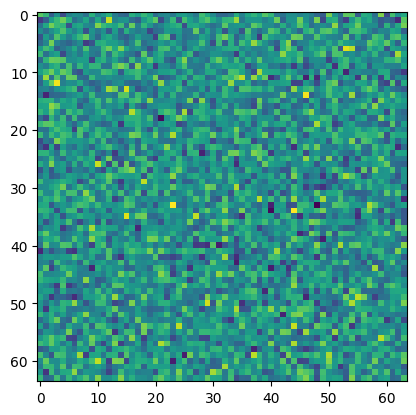

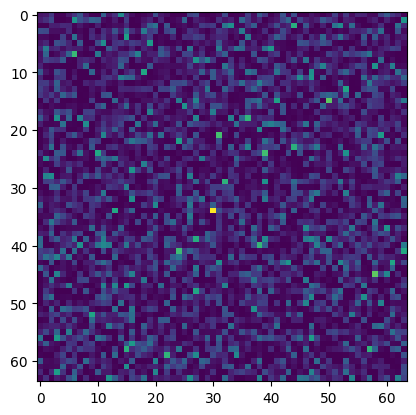

In [46]:
plt.imshow(x[0][0])  
plt.show()
plt.imshow(output[0][0].detach().numpy())
plt.show()

In [ ]:
class SNI(nn.Module):
	'''
	https://github.com/AlanLi1997/rethinking-fpn
	soft nearest neighbor interpolation for up-sampling
	secondary features aligned
	'''
	def __init__(self, c1=0, c2=0, up_f=2):
		super(SNI, self).__init__()
		self.us = nn.Upsample(None, up_f, 'nearest')
		self.alpha = 1/(up_f**2)

	def forward(self, x):
		return self.alpha*self.us(x)


In [ ]:
class GSConvE(nn.Module):
	'''
	GSConv enhancement for representation learning: generate various receptive-fields and
	texture-features only in one Conv module
	https://github.com/AlanLi1997/slim-neck-by-gsconv
	'''
	def __init__(self, c1, c2, k=1, s=1, g=1, d=1, act=True):
		super().__init__()
		c_ = c2 // 2
		self.cv1 = Conv(c1, c_, k, s, None, g, d, act)
		self.cv2 = nn.Sequential(
			nn.Conv2d(c_, c_, 3, 1, 1, bias=False),
			nn.Conv2d(c_, c_, 3, 1, 1, groups=c_, bias=False),
			nn.GELU()
		)

	def forward(self, x):
		x1 = self.cv1(x)
		x2 = self.cv2(x1)
		y = torch.cat((x1, x2), dim=1)
		# shuffle
		y = y.reshape(y.shape[0], 2, y.shape[1] // 2, y.shape[2], y.shape[3])
		y = y.permute(0, 2, 1, 3, 4)
		return y.reshape(y.shape[0], -1, y.shape[3], y.shape[4])


| Class Name| Total | Train-80% | Val-10% | Test-10%|
| ----------------- | ----------------- | ----------------- | ----------------- | ----------------- |
| cavity | 6340 | 5706 | 634 | 634 |
| ground | 3503 | 2802 | 350 | 351 |
| manhole | 4180 | 3344 | 418 | 418 |
| pipe | 5645 | 4516 | 564 | 565 |